In [1]:
import torch
import os
import copy
import mne
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


mne.set_log_level('ERROR')
if torch.cuda.is_available():
    print('CUDA-enabled GPU found. Training should be faster.')
else:
    print('No GPU found. Training will be carried out on CPU, which might be slower')

%matplotlib inline

CUDA-enabled GPU found. Training should be faster.


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Import File Names

In [3]:
## IMPORT FILE NAMES FOR SLEEP CASSETTE

import glob
import os
local_dir = "/kaggle/input/sleep-edf-and-apnea/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-cassette"
edf_files = sorted(glob.glob(os.path.join(local_dir, "*.edf")))
list_small = []
list_big = []
for i,edf_file in enumerate(edf_files):  
    directory_parts = edf_file.split("/")
    file_name = directory_parts[-1].split(".")[0]
    signal_type=file_name.split("-")[-1]
    subject_name= file_name.split("-")[0]  
    if signal_type=='PSG':
        list_small.append(edf_file)   
    elif signal_type=='Hypnogram':
        hypnogram_path = os.path.join(local_dir, f"{subject_name}-Hypnogram.edf")
        list_small.append(hypnogram_path)
        list_big.append(list_small)
        list_small = []
print(list_big[0])
fnames_cst=list_big

['/kaggle/input/sleep-edf-and-apnea/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001E0-PSG.edf', '/kaggle/input/sleep-edf-and-apnea/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf']


In [5]:
## IMPORT FILE NAMES FOR SLEEP TELEMETRY

local_dir = "/kaggle/input/sleep-edf-and-apnea/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry"
edf_files = sorted(glob.glob(os.path.join(local_dir, "*.edf")))
list_small = []
list_big = []
for i,edf_file in enumerate(edf_files):
    directory_parts = edf_file.split("/")
    file_name = directory_parts[-1].split(".")[0]
    signal_type=file_name.split("-")[-1]
    subject_name= file_name.split("-")[0]  
    if signal_type=='PSG':
        list_small.append(edf_file)      
    elif signal_type=='Hypnogram':
        hypnogram_path = os.path.join(local_dir, f"{subject_name}-Hypnogram.edf")
        list_small.append(hypnogram_path)
        list_big.append(list_small)
        list_small = []
print(list_big[0])
fnames_tlm=list_big

['/kaggle/input/sleep-edf-and-apnea/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/ST7011J0-PSG.edf', '/kaggle/input/sleep-edf-and-apnea/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/ST7011JP-Hypnogram.edf']


In [4]:
## DATASET FOR EXPERIMENT

fnames = fnames_cst  # ONLY IMPORT CST FILES  (78 subjects - 153 files)
# fnames = fnames_tlm  # ONLY IMPORT TLM FILES  (44 Subjects - 88 Files)
# fnames = fnames_cst+fnames_tml  # IMPORT BOTH CST AND TLM FILES (122 SUBJECTS)
print(len(fnames))

153


In [5]:
'''We will import EEG signal 20 minutes before sleep and 0 or 1 minute after sleep
   However, some sleep subjects does not have any record prior to sleep onset, for those we define before and after as 0 mins '''

def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True):   
    try:
        crop_wake_mins_start=20
        crop_wake_mins_end=1
        mapping = {'EOG horizontal': 'eog',
                   'Resp oro-nasal': 'misc',
                   'EMG submental': 'misc',
                   'Temp rectal': 'misc',
                   'Event marker': 'misc'}
        exclude = mapping.keys() if load_eeg_only else ()
        raw = mne.io.read_raw_edf(raw_fname, exclude=exclude, preload=True)    
        channels_to_pick = ['EEG Fpz-Cz','EEG Pz-Oz']   #
        raw.pick_channels(channels_to_pick)   
        annots = mne.read_annotations(annot_fname)
        raw.set_annotations(annots, emit_warning=False)    
        if not load_eeg_only:            
            raw.set_channel_types(mapping)   
        if crop_wake_mins_start > 0: 
            mask = [x[-1] in ['1', '2', '3', '4', 'R']   
                    for x in annots.description]        
            sleep_event_inds = np.where(mask)[0]        
            tmin = annots[int(sleep_event_inds[0])]['onset'] - crop_wake_mins_start * 60
            tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
                   crop_wake_mins_end * 60 + annots[int(sleep_event_inds[-1])]['duration']
            raw.crop(tmin=tmin, tmax=tmax)
        ch_names = {i: i.replace('EEG ', '') 
                    for i in raw.ch_names if 'EEG' in i}
        mne.rename_channels(raw.info, ch_names)
        basename = os.path.basename(raw_fname)
        subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
        raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb} 
    except:     
        crop_wake_mins_start=0
        crop_wake_mins_end=0
        mapping = {'EOG horizontal': 'eog',
                   'Resp oro-nasal': 'misc',
                   'EMG submental': 'misc',
                   'Temp rectal': 'misc',
                   'Event marker': 'misc'}
        exclude = mapping.keys() if load_eeg_only else ()
        raw = mne.io.read_raw_edf(raw_fname, exclude=exclude, preload=True)     
        channels_to_pick = ['EEG Fpz-Cz','EEG Pz-Oz']   
        raw.pick_channels(channels_to_pick)       
        annots = mne.read_annotations(annot_fname)
        raw.set_annotations(annots, emit_warning=False)  
        if not load_eeg_only:            
            raw.set_channel_types(mapping)   
        if crop_wake_mins_start > 0: 
            mask = [x[-1] in ['1', '2', '3', '4', 'R']  
                    for x in annots.description]         
            sleep_event_inds = np.where(mask)[0]         
            tmin = annots[int(sleep_event_inds[0])]['onset'] - crop_wake_mins_start * 60
            tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
                   crop_wake_mins_end * 60 + annots[int(sleep_event_inds[-1])]['duration']
            raw.crop(tmin=tmin, tmax=tmax)
        ch_names = {i: i.replace('EEG ', '') 
                    for i in raw.ch_names if 'EEG' in i}
        mne.rename_channels(raw.info, ch_names)
        basename = os.path.basename(raw_fname)
        subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
        raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb} 
    return raw
raws = []
error = []
for er,f in enumerate(fnames):
    if er>=0:
        try:
            raw = load_sleep_physionet_raw(f[0], f[1])
            raws.append(raw)
        except Exception as e:
            print(f"Ignoring error: {e}")
            error.append(er)
        if er==None:
            break
        if er%10==0 and er!=0:
            print(f"iteration completed:{er}")
print(f"Total files loaded: {len(raws)}")
print(f"Total error in anotation:{len(error)}")

iteration completed:10
iteration completed:20
iteration completed:30
Total files loaded: 41
Total error in anotation:0


In [6]:
from torch.utils.data import Dataset, ConcatDataset

def extract_epochs(raw, chunk_duration=30., epoch_length=3):
    try:
        annotation_desc_2_event_id = {
            'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3': 4,
            'Sleep stage 4': 4,
            'Sleep stage R': 5}
        events, _ = mne.events_from_annotations(
            raw, event_id=annotation_desc_2_event_id, 
            chunk_duration=chunk_duration)
        event_id = {
            'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}
        tmax = 30. - (1. / raw.info['sfreq']) 
        picks = mne.pick_types(raw.info, eeg=True, eog=True)
        epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                            event_id=event_id, tmin=0., tmax=tmax, baseline=None)
        data, labels = epochs.get_data(), epochs.events[:, 2] - 1
        combined_data, combined_labels = [], []
        for i in range(len(data) - epoch_length + 1):
            combined_data.append(np.concatenate(data[i:i + epoch_length], axis=-1))
            combined_labels.append(labels[i + epoch_length - 1])  
    except:
        annotation_desc_2_event_id_altr = {
            'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage R': 5}
        events, _ = mne.events_from_annotations(
            raw, event_id=annotation_desc_2_event_id, 
            chunk_duration=chunk_duration)
        event_id = {
            'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage R': 5}
        tmax = 30. - (1. / raw.info['sfreq'])  
        picks = mne.pick_types(raw.info, eeg=True, eog=True)
        epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                            event_id=event_id, tmin=0., tmax=tmax, baseline=None)
        data, labels = epochs.get_data(), epochs.events[:, 2] - 1
        combined_data, combined_labels = [], []
        for i in range(len(data) - epoch_length + 1):
            combined_data.append(np.concatenate(data[i:i + epoch_length], axis=-1))
            combined_labels.append(labels[i + epoch_length - 1]) 
    return np.array(combined_data), np.array(combined_labels)

class EpochsDataset(Dataset):
    def __init__(self, epochs_data, epochs_labels, subj_nb=None, 
                 rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform
    def __len__(self):
        return len(self.epochs_labels)
    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X[None, ...])
        return X, y
def scale(X):
    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)
all_datasets = []
error_2 =[]
valid_sub=[]
for i,raw in enumerate(raws):
    try:
        epochs_data = extract_epochs(raw)
        subj_nb = raw.info['subject_info']['id']
        rec_nb = raw.info['subject_info']['rec_id']
        dataset = EpochsDataset(*epochs_data, subj_nb=subj_nb, rec_nb=rec_nb, transform=scale)
        all_datasets.append(dataset)
        valid_sub.append(subj_nb)
    except Exception as e:
        print(f"found error in {i}")
        print(e)
        error_2.append(i)
    if i==None:
        break
    if i%10==0 and i!=0:
        print(f"Total Recording Loaded:{i}")
print(f"Total error file: {len(error_2)}")
dataset = ConcatDataset(all_datasets)

Total Recording Loaded:10
Total Recording Loaded:20
Total Recording Loaded:30
Total Recording Loaded:40
Total error file: 0


In [7]:
from sklearn.model_selection import LeavePGroupsOut

def pick_recordings(dataset, subj_rec_nbs):
    pick_idx = list()                              
    for subj_nb, rec_nb in subj_rec_nbs:
        for i, ds in enumerate(dataset.datasets):
            if (ds.subj_nb == subj_nb) and (ds.rec_nb == rec_nb):
                pick_idx.append(i)
    print(f"test files: {pick_idx}")           
    remaining_idx = np.setdiff1d(
        range(len(dataset.datasets)), pick_idx)
    print(f" train+val {remaining_idx}")
    pick_ds = ConcatDataset([dataset.datasets[i] for i in pick_idx])
    if len(remaining_idx) > 0:
        remaining_ds = ConcatDataset(
            [dataset.datasets[i] for i in remaining_idx])
    else:
        remaining_ds = None    
    return pick_ds, remaining_ds
    
def train_test_split(dataset, n_groups, split_by='subj_nb'):
    groups = [getattr(ds, split_by) for ds in dataset.datasets]
    print(groups)
    train_idx, test_idx = next(
        LeavePGroupsOut(n_groups).split(X=groups, groups=groups))
    print(len(train_idx))
    print(len(test_idx))
    train_ds = ConcatDataset([dataset.datasets[i] for i in train_idx])
    test_ds = ConcatDataset([dataset.datasets[i] for i in test_idx]) 
    return train_ds, test_ds

result = []
fst_sub = dataset.datasets[0].subj_nb
total_sub=4   ## Number of subject in test set
for i in range(fst_sub,fst_sub+total_sub):
    if i in [2, 4]:
        continue
    for j in range(1, 3):
        result.append((i, j))
print(result)
test_recs = [(subj_nb, rec_nb)  
             for subj_nb, rec_nb in result]
test_ds, train_ds = pick_recordings(dataset, test_recs)

[(0, 1), (0, 2), (1, 1), (1, 2), (3, 1), (3, 2)]
test files: [0, 1, 2, 3, 6, 7]
 train+val [ 4  5  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 32 33 34 35 36 37 38 39 40]


In [58]:
split = 25
k = 1//split
n_subjects_valid = max(1, int(len(train_ds.datasets) * k))
train_ds, valid_ds = train_test_split(train_ds, n_subjects_valid, split_by='subj_nb')
print('Number of examples in each set:')
print(f'Number of Training Segments: {len(train_ds)}')
print(f'Number of Validation Segments: {len(valid_ds)}')
print(f'Number of Test Segments: {len(test_ds)}')

[4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20]
31
2
Number of examples in each set:
Number of Training Segments: 31281
Number of Validation Segments: 2275
Number of Test Segments: 5640


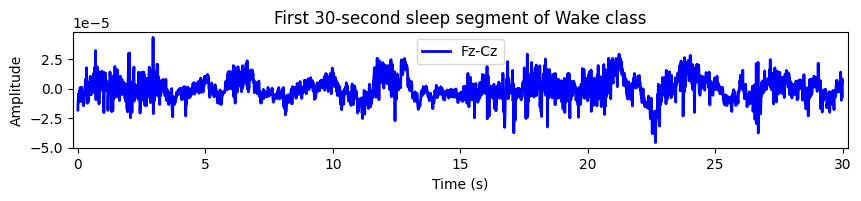

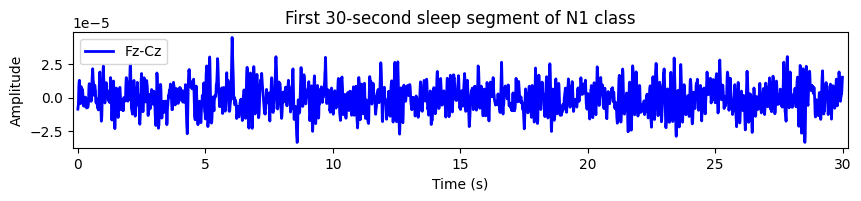

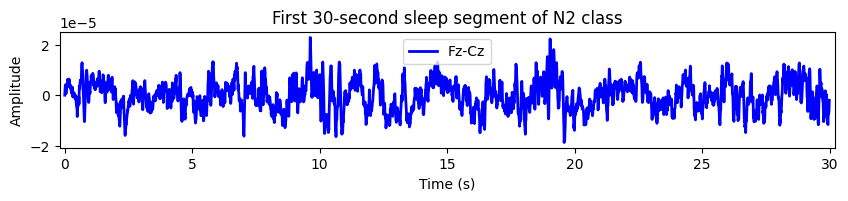

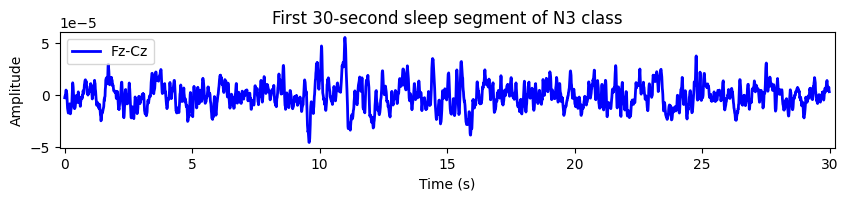

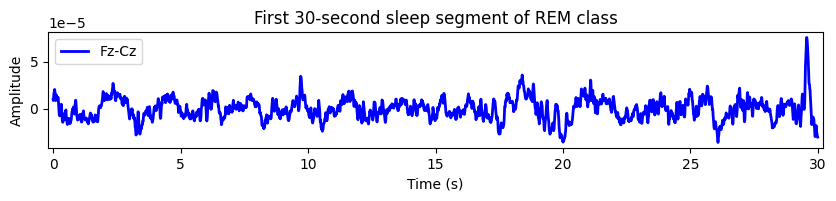

In [9]:
raw = raws[0]
epochs_data, labels = extract_epochs(raw)
i=0  
for l in range(0,5):
    first_label_2_index = np.where(labels == l)[0][i]
    first_label_2_epoch = epochs_data[first_label_2_index]
    time = np.arange(3000) / 100  
    plt.figure(figsize=(10, 1.5))
    plt.plot(time, first_label_2_epoch[1][:3000], label='Fz-Cz', color='blue', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    if l==0:
        classs='Wake'
    elif l==1:
        classs ='N1'
    elif l==2:
        classs ='N2'
    elif l==3:
        classs ='N3'
    elif l==4:
        classs ='REM'
    plt.title(f'First 30-second sleep segment of {classs} class')
    plt.legend()
    plt.xlim(-0.2, 30.2)
    plt.show()

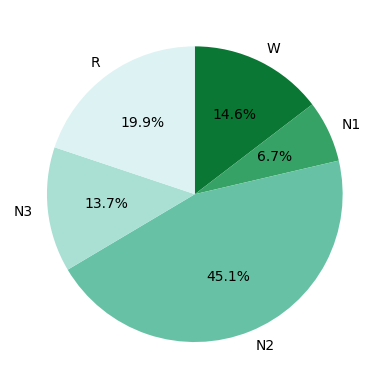

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

classes_mapping = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'R'}
y_train = pd.Series([y for _, y in train_ds]).map(classes_mapping)
class_order = [classes_mapping[i] for i in range(len(classes_mapping))]
value_counts = y_train.value_counts()
ordered_value_counts = value_counts.reindex(class_order)
colors = sns.color_palette("BuGn_r", len(class_order))
fig, ax = plt.subplots()
ax.pie(ordered_value_counts,
       labels=class_order,
       colors=colors,
       autopct='%1.1f%%',
       startangle=90,
       counterclock=False)
plt.show()


## NeuroSleepNet_SIAM

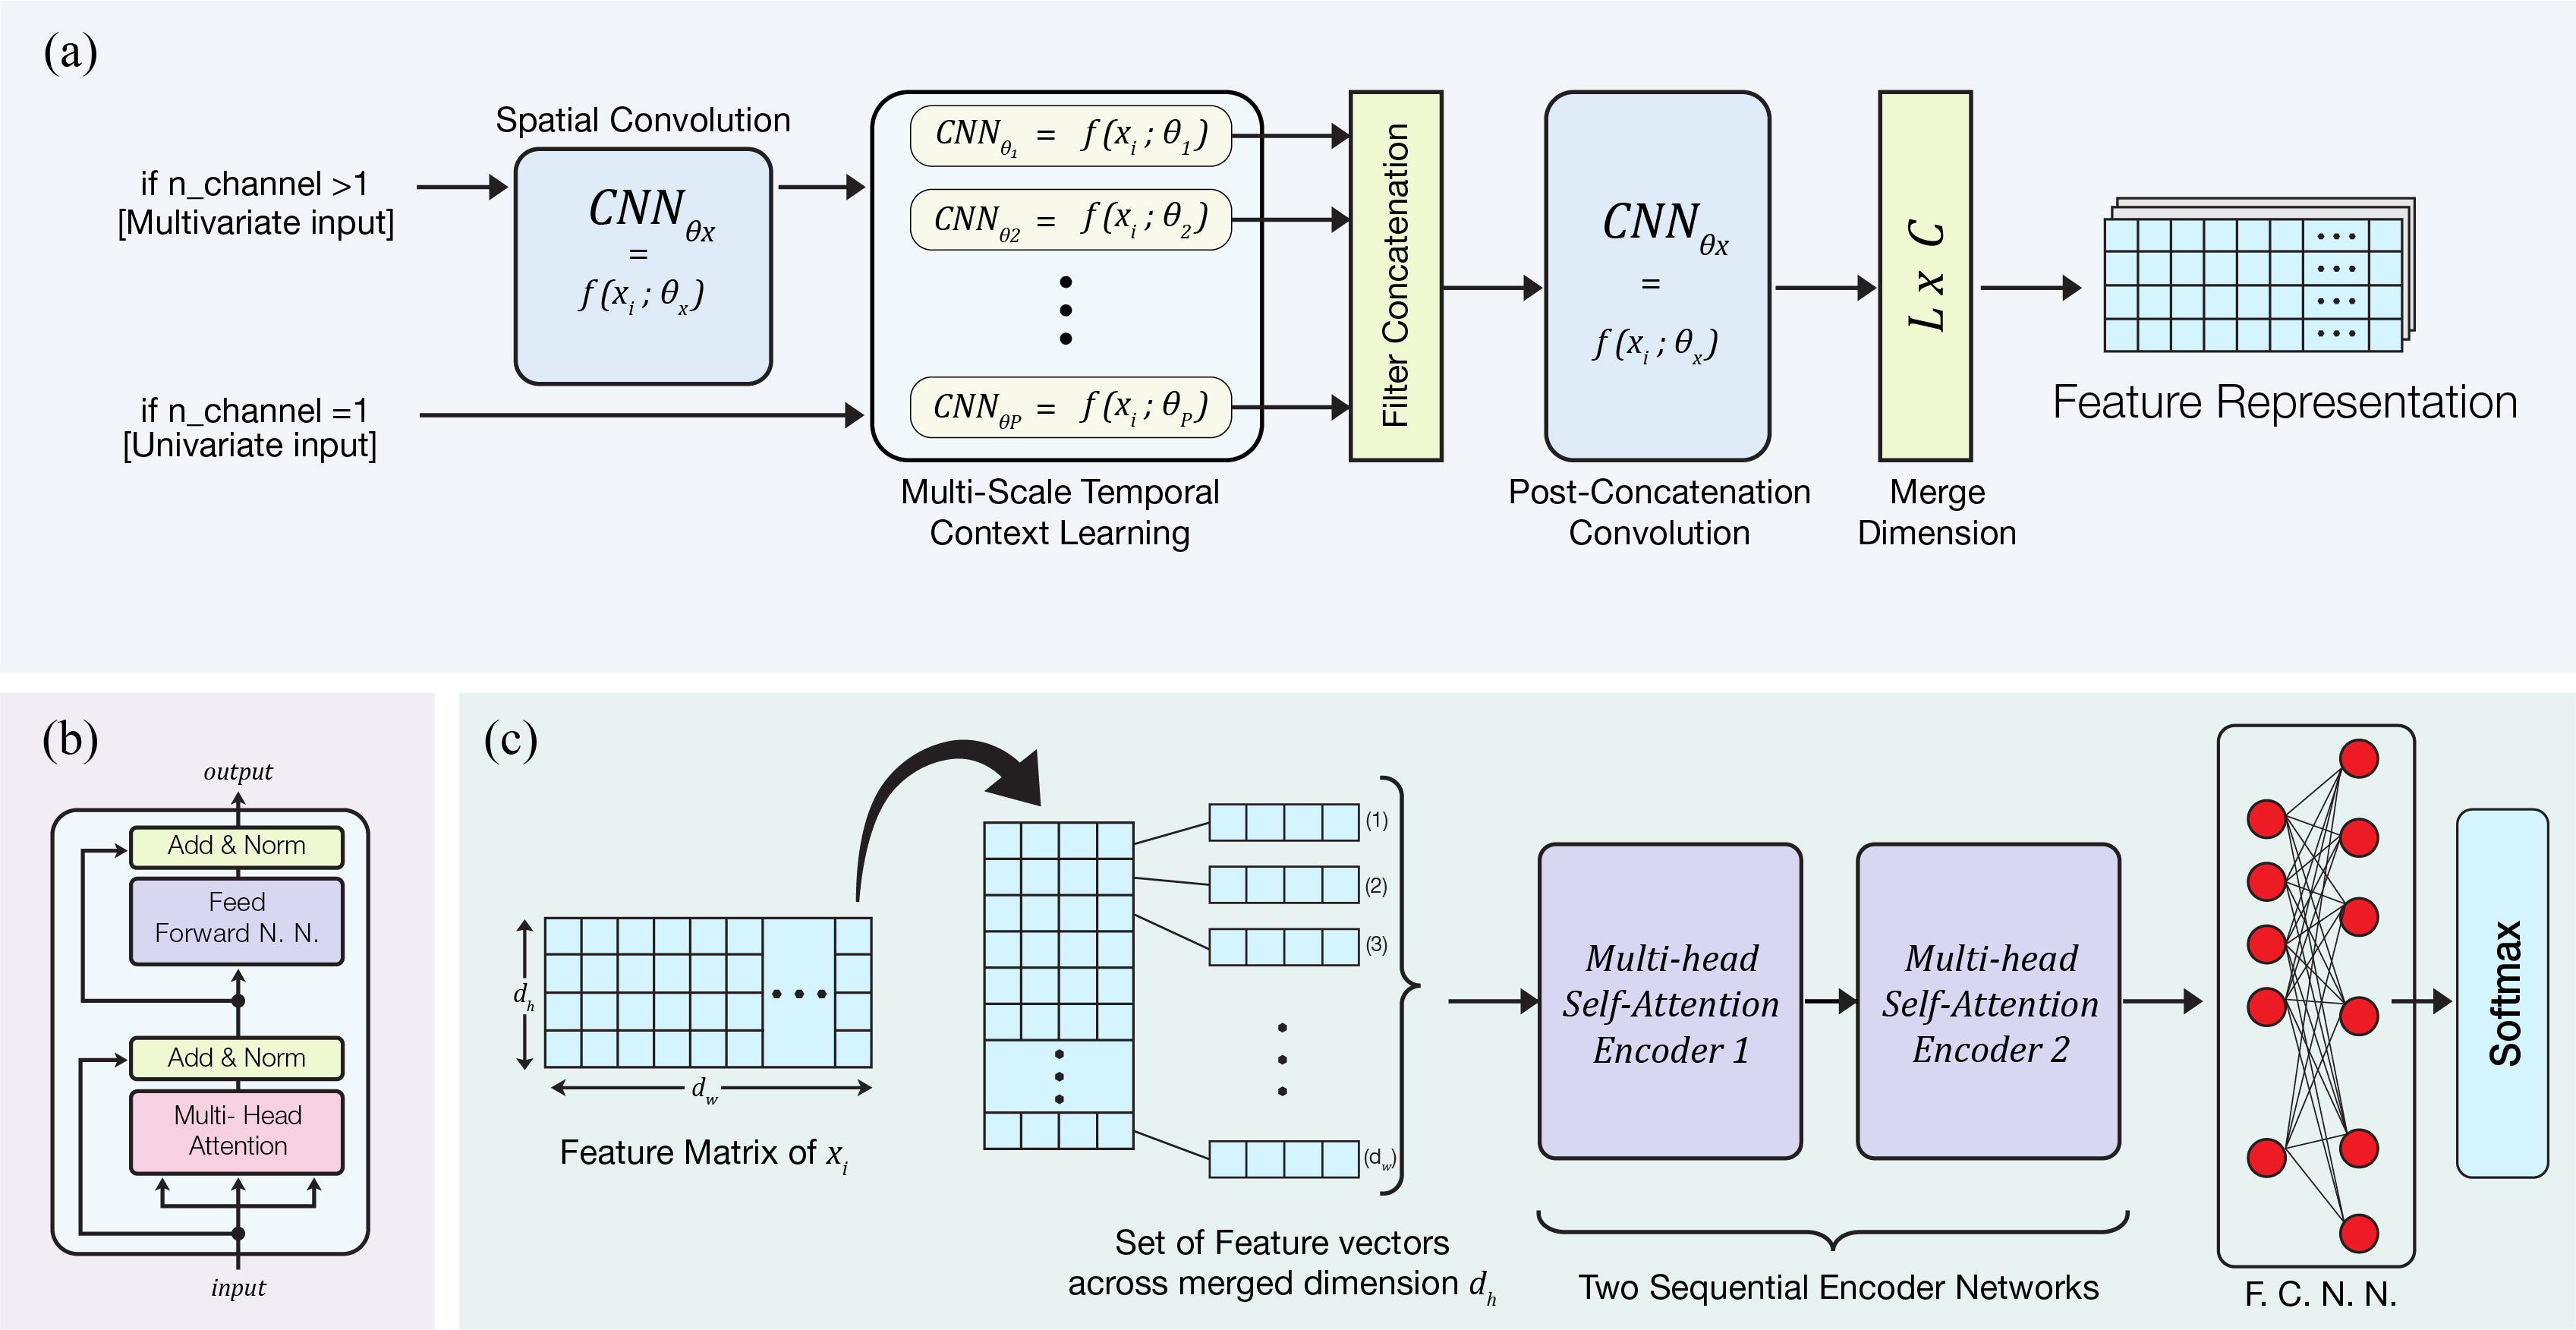!

## Model Implementation (using nn module from torch)

In [45]:
from torch import nn
import torch

class NeuroSleepNet_SIAM(nn.Module):
    def __init__(self, n_channels, sfreq, mtcl_scales,
                 n_conv_chs=8, time_conv_size_s=.25,
                 max_pool_size_s=0.125, n_classes=5, input_size_s=30,
                 dropout=0.25, num_heads=4, num_layers=2, seq_len=3000):
        super().__init__()
        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = int(max_pool_size_s * sfreq)
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        P = mtcl_scales
        self.P = P
        
        # Spatial Convolutonal Operation
        
        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))
        
        # Multi- Scale Temporal Context Learning
        
        self.feature_extractor1_1 = nn.Sequential(
            nn.Conv2d(1, n_conv_chs,
                      (1, time_conv_size),
                      padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )  
        self.feature_extractor1_2 = nn.Sequential(
            nn.Conv2d(1, n_conv_chs,
                      (1, time_conv_size * 2),
                      padding=(0, pad_size * 2 + 1)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )    
        self.feature_extractor1_3 = nn.Sequential(
            nn.Conv2d(1, n_conv_chs,
                      (1, time_conv_size * 4),
                      padding=(0, pad_size * 4 + 5)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )   

        
        # Post-Concatenation Convolution (PCC)
        
        self.feature_extractor_PCC = nn.Sequential(
            nn.Conv2d(n_conv_chs * P, n_conv_chs,
                      (1, time_conv_size),
                      padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        
        # Transformer Encoder
        
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
                                                                    d_model=n_conv_chs * n_channels,  
                                                                    nhead=num_heads,
                                                                    dropout=dropout,
                                                                    batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer,
                                                                    num_layers=num_layers)
        len_last_layer = n_conv_chs * n_channels  
        self.fc = nn.Linear(len_last_layer, n_classes)
   

    def forward(self, x):
        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)  

        feature_outputs = []
        for i in range(1, self.P + 1):
            feature_extractor = getattr(self, f'feature_extractor1_{i}')
            feature_outputs.append(feature_extractor(x))
        x = torch.cat(feature_outputs, dim=1)  
        x = self.feature_extractor_PCC(x)
        x = x.view(x.size(0), -1, x.size(3))  
        x = x.permute(0, 2, 1)   
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        

        x = self.fc(x.flatten(start_dim=1))      
        return x

sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']   #Number of Channel
model = NeuroSleepNet_SIAM(n_channels, sfreq, n_classes=5, mtcl_scales=3)
print(f"Signal Sampling Freq :{sfreq}")
print(f"Number of Channels: {n_channels}")
model = model.to(device)
print(f'Using device \'{device}\'.')
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")


Signal Sampling Freq :100.0
Number of Channels:2
Using device 'cuda'.
Total number of parameters: 217395


## Log-based weight calculation

In [46]:
import numpy as np
import torch
from torch.nn import CrossEntropyLoss

class ClassWeightCalculator:
    def __init__(self, train_datasets, device):

        self.train_datasets = train_datasets
        self.device = device

    def compute_class_weights(self):

        train_y = np.concatenate([ds.epochs_labels for ds in self.train_datasets])
        class_freq = np.bincount(train_y)
        total_samples = len(train_y)
        class_weights_log = np.log(total_samples / class_freq)
        class_weights_log_tensor = torch.Tensor(class_weights_log).to(self.device)
        return class_weights_log_tensor

    def get_loss_function(self):

        class_weights_tensor = self.compute_class_weights()
        return CrossEntropyLoss(weight=class_weights_tensor)

class_weight_calculator = ClassWeightCalculator(train_datasets=train_ds.datasets, device=device)
class_weights_tensor = class_weight_calculator.compute_class_weights()
print(class_weights_tensor)

tensor([1.9234, 2.6974, 0.7959, 1.9900, 1.6163], device='cuda:0')


### LOAD ALREADY TRAINED MODEL (Run only when evaluate older model) <br><br>
If you run this then direct jump to evaluation cell

In [ ]:
model_path = "/kaggle/input/sleep-models/Sleep-EDS_S3_run_1.pth"
sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']   #Number of Channel
classes=5        # User defined
scales=3         # User defined
model = NeuroSleepNet_SIAM(n_channels,
                           sfreq,
                           n_classes=classes,
                           mtcl_scales=scales) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Initial weights:", model.fc.weight[:1])
try:
    model.load_state_dict(torch.load(model_path))
    print("Model weights loaded successfully.")
except Exception as e:
    print(f"Failed to load model weights: {e}")
print("Loaded weights:", model.fc.weight[:1])

## Train from Scrach using Pytorch Lightning

In [61]:
import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
class MyLightningModule(pl.LightningModule):
    def __init__(self, model, class_weights, lr=1e-3, weight_decay=1e-3, metric=None):
        super(MyLightningModule, self).__init__()
        self.model = model.to(device)
        self.criterion = CrossEntropyLoss(weight=torch.Tensor(class_weights).to(self.device))
        self.lr = lr
        self.weight_decay = weight_decay
        self.metric = metric if metric is not None else balanced_accuracy_score
        self.test_preds = []
        self.test_labels = []
    def forward(self, x):
        return self.model(x)
    def configure_optimizers(self):
        return Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(self.device, dtype=torch.float32)
        y = y.to(self.device, dtype=torch.int64)
        output = self.model(x)
        loss = self.criterion(output, y)
        preds = torch.argmax(output, axis=1)
        perf = self.metric(y.cpu().numpy(), preds.cpu().numpy())
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_perf', perf, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        if len(y) == 0:
            return  # Skip empty batch
        x = x.to(self.device, dtype=torch.float32)
        y = y.to(self.device, dtype=torch.int64)
        output = self.model(x)
        loss = self.criterion(output, y)
        preds = torch.argmax(output, axis=1)
        perf = self.metric(y.cpu().numpy(), preds.cpu().numpy())
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_perf', perf, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(self.device, dtype=torch.float32)
        y = y.to(self.device, dtype=torch.int64)
        output = self.model(x)
        loss = self.criterion(output, y)
        preds = torch.argmax(output, axis=1)
        perf = self.metric(y.cpu().numpy(), preds.cpu().numpy())
        self.test_preds.append(preds.cpu().numpy())
        self.test_labels.append(y.cpu().numpy())
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_perf', perf, on_step=False, on_epoch=True, prog_bar=True)
        return loss

train_batch_size = 512
valid_batch_size = 256
num_workers = 4  
loader_train = DataLoader(train_ds,
                          batch_size=train_batch_size,
                          shuffle=True,
                          num_workers=num_workers)
loader_valid = DataLoader(valid_ds,
                          batch_size=valid_batch_size,
                          shuffle=False,
                          num_workers=num_workers)
loader_test = DataLoader(test_ds,
                         batch_size=valid_batch_size,
                         shuffle=False,
                         num_workers=num_workers)
n_epochs = 5
patience = 65
sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']   #Number of Channel
classes=5        # User defined
scales=3         # User defined
model = NeuroSleepNet_SIAM(n_channels,
                           sfreq,
                           n_classes=classes,
                           mtcl_scales=scales)   
class_weights = class_weights_tensor 
pl_model = MyLightningModule(model,
                             class_weights,
                             metric=balanced_accuracy_score)
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
trainer = pl.Trainer(
    max_epochs=n_epochs,
    callbacks=[early_stop_callback],
    logger=pl.loggers.TensorBoardLogger('lightning_logs', name='my_model')
)
trainer.fit(pl_model, loader_train, loader_valid)
trainer.test(pl_model, loader_test)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.7010538578033447     │
│         test_perf         │    0.6556829810142517     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7010538578033447, 'test_perf': 0.6556829810142517}]

## Performance Evaluation for Pytorch Lighning

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['val_loss', 'val_perf', 'epoch', 'train_loss', 'train_perf', 'test_loss', 'test_perf'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


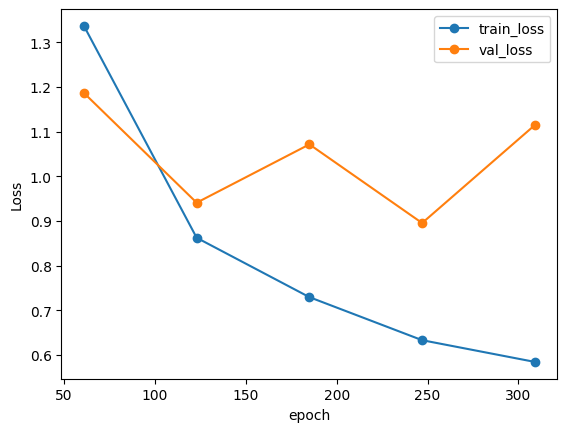

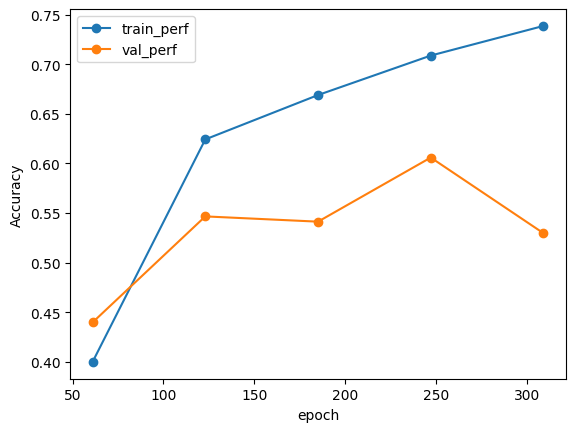

In [62]:
log_dir = trainer.logger.log_dir
event_acc = EventAccumulator(log_dir)
event_acc.Reload()
print(event_acc.Tags())
train_loss = event_acc.Scalars('train_loss')
val_loss = event_acc.Scalars('val_loss')
train_perf = event_acc.Scalars('train_perf')
val_perf = event_acc.Scalars('val_perf')
history = {
    'epoch': [x.step for x in train_loss],
    'train_loss': [x.value for x in train_loss],
    'val_loss': [x.value for x in val_loss],
    'train_perf': [x.value for x in train_perf],
    'val_perf': [x.value for x in val_perf]
}
history_df = pd.DataFrame(history)
ax1 = history_df.plot(x='epoch', y=['train_loss', 'val_loss'], marker='o')
ax1.set_ylabel('Loss')
ax2 = history_df.plot(x='epoch', y=['train_perf', 'val_perf'], marker='o')
ax2.set_ylabel('Accuracy')
plt.show()

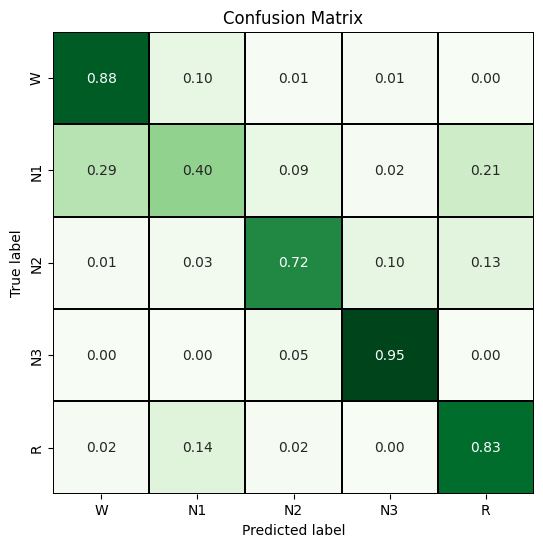

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap=plt.cm.Reds, linewidths=0.5, linecolor='k', save_path=None):
    plt.figure(figsize=(6.2, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap=cmap, xticklabels=class_names, yticklabels=class_names, 
                linewidths=linewidths, linecolor=linecolor, cbar=False)  
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save_path:
        plt.savefig(save_path, format='jpg', bbox_inches='tight')
    plt.show()
    
y_true = np.concatenate(pl_model.test_labels)
y_pred = np.concatenate(pl_model.test_preds)
rec_ids = np.concatenate(  
    [[i] * len(ds) for i, ds in enumerate(test_ds.datasets)])
conf_mat = confusion_matrix(y_true, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
conf_mat_percentage = conf_mat_normalized 
class_names = [classes_mapping[i] for i in range(len(classes_mapping))]
save_path = "/kaggle/working/cm_sleepEDF_p=2.jpg"
plot_confusion_matrix(conf_mat_percentage, class_names, cmap='Greens', linewidths=0.003, linecolor='k', save_path=save_path)


In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import f1_score

y_true_class = y_true
y_pred_class = y_pred
print("Accuracy:", accuracy_score(y_true_class, y_pred_class))
print("Balanced Accuracy:", balanced_accuracy_score(y_true_class, y_pred_class))
print("Precision (macro):", precision_score(y_true_class, y_pred_class, average='macro'))
print("Recall (macro):", recall_score(y_true_class, y_pred_class, average='macro'))
print("F1-Score (macro):", f1_score(y_true_class, y_pred_class, average='macro'))

per_class_f1_scores = f1_score(y_true_class, y_pred_class, average=None)
for i, score in enumerate(per_class_f1_scores):
    print(f"F1-Score for class {i}: {score:.5f}")

print("Confusion Matrix:\n", confusion_matrix(y_true_class, y_pred_class))

Accuracy: 0.8072695035460993
Balanced Accuracy: 0.7092421334353086
Precision (macro): 0.7269980410569928
Recall (macro): 0.7092421334353086
F1-Score (macro): 0.6971503514424817
F1-Score for class 0: 0.80396
F1-Score for class 1: 0.18671
F1-Score for class 2: 0.88086
F1-Score for class 3: 0.85203
F1-Score for class 4: 0.76219
Confusion Matrix:
 [[ 365   56    8    5   52]
 [  55   52   46    6  265]
 [   2    0 2303  173  252]
 [   0    0   97  809    0]
 [   0   25   45    0 1024]]


<bound method _AxesBase.set_yticks of <Axes: >>

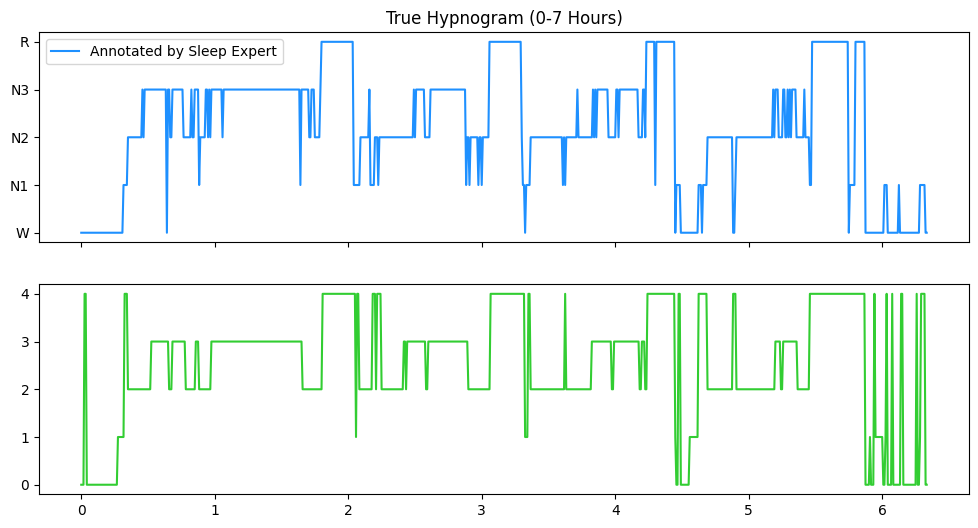

In [63]:
import numpy as np
import matplotlib.pyplot as plt
mask = rec_ids == 0 
fs = 100  
epoch_length = 30
start_time = 0 
end_time = start_time + 7   ## mane 7 ghonta
start_time_seconds = start_time * 3600
end_time_seconds = end_time * 3600
start_epoch = int(start_time_seconds / epoch_length)
end_epoch = int(end_time_seconds / epoch_length)
y_true_period = y_true[mask][start_epoch:end_epoch]
y_pred_period = y_pred[mask][start_epoch:end_epoch]
t_period = np.arange(len(y_true_period)) * epoch_length / 3600 + start_time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax1.plot(t_period, y_true_period, color='dodgerblue', label='Annotated by Sleep Expert')
ax1.set_yticks([0, 1, 2, 3, 4])
ax1.set_yticklabels(['W', 'N1', 'N2', 'N3', 'R'])
ax1.set_title(f'True Hypnogram ({start_time}-{end_time} Hours)')
ax1.legend()
ax2.plot(t_period, y_pred_period, color='limegreen', label='Predicted by NeuroSleepNet')
ax2.set_yticks


## Straightforward Single RUN (Without PyTorch Lightning)

In [47]:
from torch.utils.data import DataLoader


train_batch_size = 512
valid_batch_size = 256 
num_workers = 0  

loader_train = DataLoader(train_ds,
                          batch_size=train_batch_size,
                          shuffle=True,
                          num_workers=num_workers)
loader_valid = DataLoader(valid_ds,
                          batch_size=valid_batch_size,
                          shuffle=False,
                          num_workers=num_workers)
loader_test = DataLoader(test_ds,
                          batch_size=valid_batch_size,
                          shuffle=False,
                          num_workers=num_workers)

y_pred_all, y_true_all = list(), list()
for batch_x, batch_y in loader_test:
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    y_true_all.append(batch_y.cpu().numpy())
y_true = np.concatenate(y_true_all)
rec_ids = np.concatenate([[i] * len(ds) for i, ds in enumerate(test_ds.datasets)])

In [48]:
import torch
import numpy as np
import copy
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, accuracy_score

def _do_train(model, loader, optimizer, criterion, device, metric):
    model.train()  
    train_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    for idx_batch, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.int64)
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()  
        y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
        y_true_all.append(batch_y.cpu().numpy())
        train_loss[idx_batch] = loss.item()
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)
    return np.mean(train_loss), perf
        

def _validate(model, loader, criterion, device, metric):
    model.eval()
    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    with torch.no_grad():
        for idx_batch, (batch_x, batch_y) in enumerate(loader):
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y = batch_y.to(device=device, dtype=torch.int64)
            output = model.forward(batch_x)
            loss = criterion(output, batch_y)
            val_loss[idx_batch] = loss.item()
            y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)
    return np.mean(val_loss), perf


def train(model, loader_train, loader_valid, optimizer, criterion, n_epochs, 
          patience, device, metric=None):
    best_valid_loss = np.inf
    best_model_state = None
    waiting = 0
    history = list()
    if metric is None:
        metric = accuracy_score
        
    print('epoch \t train_loss \t valid_loss \t train_perf \t valid_perf')
    print('-------------------------------------------------------------------')

    for epoch in range(1, n_epochs + 1):
        train_loss, train_perf = _do_train(
            model, loader_train, optimizer, criterion, device, metric=metric)
        valid_loss, valid_perf = _validate(
            model, loader_valid, criterion, device, metric=metric)
        history.append(
            {'epoch': epoch, 
             'train_loss': train_loss, 'valid_loss': valid_loss,
             'train_perf': train_perf, 'valid_perf': valid_perf})
        
        print(f'{epoch} \t {train_loss:0.4f} \t {valid_loss:0.4f} '
              f'\t {train_perf:0.4f} \t {valid_perf:0.4f}')

        # model saving
        if valid_loss < best_valid_loss:
            print(f'best val loss {best_valid_loss:.4f} -> {valid_loss:.4f}')
            best_valid_loss = valid_loss
            best_model_state = copy.deepcopy(model.state_dict())
            waiting = 0
        else:
            waiting += 1
        # model early stopping
        if waiting >= patience:
            print(f'Stop training at epoch {epoch}')
            print(f'Best val loss : {best_valid_loss:.4f}')
            break

    model.load_state_dict(best_model_state)
    return model, history


In [49]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

n_epochs = 5
patience = 5
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = CrossEntropyLoss(weight=torch.Tensor(class_weights_tensor).to(device))

best_model, history = train(
                            model,
                            loader_train,
                            loader_valid,
                            optimizer,
                            criterion,
                            n_epochs,
                            patience, 
                            device,
                            metric=balanced_accuracy_score)

epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf
-------------------------------------------------------------------
1 	 1.4949 	 1.3661 	 0.2852 	 0.4853
best val loss inf -> 1.3661
2 	 1.0330 	 1.6049 	 0.5618 	 0.4781
3 	 0.8199 	 1.1018 	 0.6350 	 0.6568
best val loss 1.3661 -> 1.1018
4 	 0.7135 	 1.0622 	 0.6779 	 0.6656
best val loss 1.1018 -> 1.0622
5 	 0.6491 	 1.1988 	 0.7102 	 0.6464


## Performance Evaluation for single simplified RUN/ Loaded Model

Text(0, 0.5, 'Accuracy')

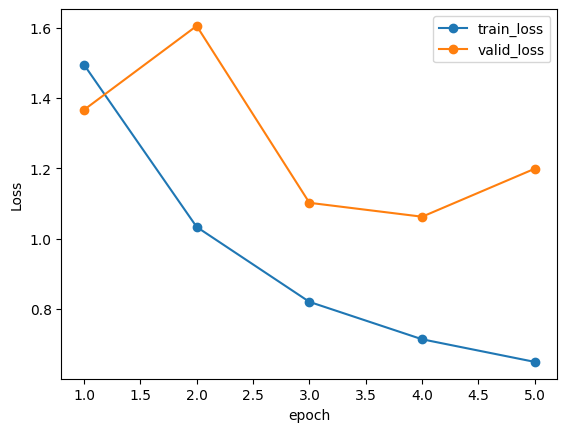

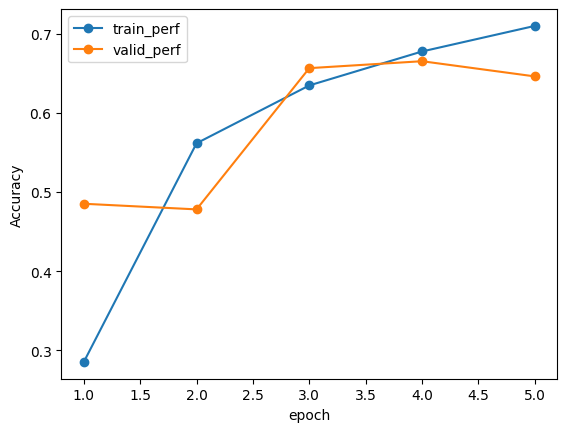

In [50]:
history_df = pd.DataFrame(history)
ax1 = history_df.plot(x='epoch', y=['train_loss', 'valid_loss'], marker='o')
ax1.set_ylabel('Loss')
ax2 = history_df.plot(x='epoch', y=['train_perf', 'valid_perf'], marker='o')
# ax2.set_ylabel('Cohen\'s kappa')
ax2.set_ylabel('Accuracy')

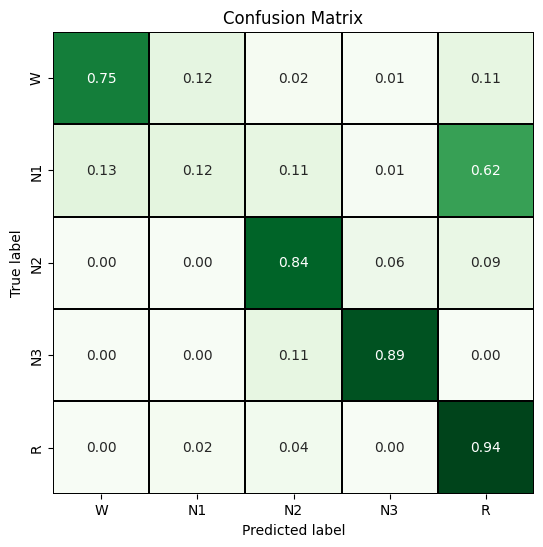

In [55]:
best_model.eval()

y_pred_all, y_true_all = list(), list()
for batch_x, batch_y in loader_test:
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    output = model.forward(batch_x)
    y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
    y_true_all.append(batch_y.cpu().numpy())
y_pred = np.concatenate(y_pred_all)
y_true = np.concatenate(y_true_all)
rec_ids = np.concatenate(  
    [[i] * len(ds) for i, ds in enumerate(test_ds.datasets)])
def plot_confusion_matrix(cm, class_names,
                          title='Confusion Matrix',
                          cmap=plt.cm.Reds,
                          linewidths=0.5,
                          linecolor='k',
                          save_path=None):
    plt.figure(figsize=(6.2, 6))
    sns.heatmap(cm, 
                annot=True,
                fmt=".2f",
                cmap=cmap,
                xticklabels=class_names,
                yticklabels=class_names, 
                linewidths=linewidths,
                linecolor=linecolor,
                cbar=False)  
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save_path:
        plt.savefig(save_path, format='jpg', bbox_inches='tight')
    plt.show()

conf_mat = confusion_matrix(y_true, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
conf_mat_percentage = conf_mat_normalized 
class_names = [classes_mapping[i] for i in range(len(classes_mapping))]
save_path = "/kaggle/working/cm_sleepEDF_p=2.jpg"
plot_confusion_matrix(conf_mat_percentage,
                      class_names,
                      cmap='Greens',
                      linewidths=0.003,
                      linecolor='k',
                      save_path=save_path)


In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import f1_score

y_true_class = y_true
y_pred_class = y_pred
print("Accuracy:", accuracy_score(y_true_class, y_pred_class))
print("Balanced Accuracy:", balanced_accuracy_score(y_true_class, y_pred_class))
print("F1-Score (macro):", f1_score(y_true_class, y_pred_class, average='macro'))
print("Precision (macro):", precision_score(y_true_class, y_pred_class, average='macro'))
print("Recall (macro):", recall_score(y_true_class, y_pred_class, average='macro'))
test_kappa = cohen_kappa_score(y_true, y_pred)
print(f'Cohen\'s kappa: {test_kappa:0.5f}')

per_class_f1_scores = f1_score(y_true_class, y_pred_class, average=None)
for i, score in enumerate(per_class_f1_scores):
    print(f"F1-Score for class {i}: {score:.5f}")

print("Confusion Matrix:\n", confusion_matrix(y_true_class, y_pred_class))

Accuracy: 0.8072695035460993
Balanced Accuracy: 0.7092421334353086
F1-Score (macro): 0.6971503514424817
Precision (macro): 0.7269980410569928
Recall (macro): 0.7092421334353086
Cohen's kappa: 0.72239
F1-Score for class 0: 0.80396
F1-Score for class 1: 0.18671
F1-Score for class 2: 0.88086
F1-Score for class 3: 0.85203
F1-Score for class 4: 0.76219
Confusion Matrix:
 [[ 365   56    8    5   52]
 [  55   52   46    6  265]
 [   2    0 2303  173  252]
 [   0    0   97  809    0]
 [   0   25   45    0 1024]]


## Save Model

In [ ]:
import torch
torch.save(best_model.state_dict(), '/kaggle/working/Sleep-EDS_S1_single_ch_Fpz.pth')
